In [1]:
!pip install -q torch
!pip install -q darts
!pip install -q torchmetrics

In [2]:
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError
import torch
import numpy as np
import pandas as pd
from darts import TimeSeries

In [3]:

!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas


import openmeteo_requests

import requests_cache

from retry_requests import retry
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [4]:

def make_dataframe(openmeteo_response):

    hourly = openmeteo_response.Hourly()
    _start = pd.to_datetime(hourly.Time(), unit = "s", utc = True)
    _end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True)
    _delta = pd.Timedelta(seconds = hourly.Interval())

    data = {
        "date": pd.date_range(_start, _end, freq=_delta, inclusive="left"),
        "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
        "surface_pressure": hourly.Variables(1).ValuesAsNumpy(),
        "wind_speed_10m": hourly.Variables(2).ValuesAsNumpy(),
        "wind_direction_10m": hourly.Variables(3).ValuesAsNumpy(),
        "wind_gusts_10m": hourly.Variables(4).ValuesAsNumpy(),
    }

    return pd.DataFrame(data).set_index("date")

In [5]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": [47.36, 46, 47.26, 46.5],
	"longitude": [8.55, 8.95, 11.39, 11.35],
	"start_date": "2024-02-10",
	"end_date": "2024-03-15",
	"hourly": ["temperature_2m", "surface_pressure", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"]
}
data = openmeteo.weather_api(url, params=params)
data = dict(zip(("Zurich", "Lugano", "Innsbruck", "Bolzano"), data))
data = pd.concat({key: make_dataframe(val) for key, val in data.items()})

city_codes = {"Zurich": 1, "Lugano": 2, "Innsbruck": 3, "Bolzano": 4}
data['city_code'] = data.index.get_level_values(0).map(city_codes)

In [6]:
data.reset_index(inplace=True)
data['Time'] = data['date'].dt.time
data['Date'] = data['date'].dt.date
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   level_0             3360 non-null   object             
 1   date                3360 non-null   datetime64[ns, UTC]
 2   temperature_2m      3360 non-null   float32            
 3   surface_pressure    3360 non-null   float32            
 4   wind_speed_10m      3360 non-null   float32            
 5   wind_direction_10m  3360 non-null   float32            
 6   wind_gusts_10m      3360 non-null   float32            
 7   city_code           3360 non-null   int64              
 8   Time                3360 non-null   object             
 9   Date                3360 non-null   object             
dtypes: datetime64[ns, UTC](1), float32(5), int64(1), object(3)
memory usage: 197.0+ KB


In [7]:
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S', errors='ignore')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d', errors='ignore')
data['Date'] = data[('Date')].values.astype('float64')
data['Time'] = data[('Time')].values.astype('float64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   level_0             3360 non-null   object             
 1   date                3360 non-null   datetime64[ns, UTC]
 2   temperature_2m      3360 non-null   float32            
 3   surface_pressure    3360 non-null   float32            
 4   wind_speed_10m      3360 non-null   float32            
 5   wind_direction_10m  3360 non-null   float32            
 6   wind_gusts_10m      3360 non-null   float32            
 7   city_code           3360 non-null   int64              
 8   Time                3360 non-null   float64            
 9   Date                3360 non-null   float64            
dtypes: datetime64[ns, UTC](1), float32(5), float64(2), int64(1), object(1)
memory usage: 197.0+ KB


/tmp/ipykernel_32923/4016276439.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S', errors='ignore')
/tmp/ipykernel_32923/4016276439.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d', errors='ignore')


In [8]:
data.head(5)

,level_0,date,temperature_2m,surface_pressure,wind_speed_10m,wind_direction_10m,wind_gusts_10m,city_code,Time,Date
0,Zurich,2024-02-10 00:00:00+00:00,5.54,942.989197,2.520000,180.000000,5.400000,1,-2.208989e+18,1.707523e+18
1,Zurich,2024-02-10 01:00:00+00:00,6.39,942.373962,3.877318,158.198532,7.200000,1,-2.208985e+18,1.707523e+18
2,Zurich,2024-02-10 02:00:00+00:00,6.14,941.570923,3.877318,111.801476,8.280000,1,-2.208982e+18,1.707523e+18
3,Zurich,2024-02-10 03:00:00+00:00,6.34,941.034546,3.240000,90.000000,8.640000,1,-2.208978e+18,1.707523e+18
4,Zurich,2024-02-10 04:00:00+00:00,4.34,940.217163,5.014219,68.962418,7.559999,1,-2.208974e+18,1.707523e+18


In [9]:
#data_new =  data{'date', 'temperature_2m', 'surface_pressure', 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'city_code', 'Time', 'Date'}
datanew = data.drop(columns=['level_0','date'])

In [10]:
datanew = datanew.astype('float64')
datanew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature_2m      3360 non-null   float64
 1   surface_pressure    3360 non-null   float64
 2   wind_speed_10m      3360 non-null   float64
 3   wind_direction_10m  3360 non-null   float64
 4   wind_gusts_10m      3360 non-null   float64
 5   city_code           3360 non-null   float64
 6   Time                3360 non-null   float64
 7   Date                3360 non-null   float64
dtypes: float64(8)
memory usage: 210.1 KB


In [11]:
#datanew.convert_objects(convert_numeric=True)

datanew.dtypes

temperature_2m        float64
surface_pressure      float64
wind_speed_10m        float64
wind_direction_10m    float64
wind_gusts_10m        float64
city_code             float64
Time                  float64
Date                  float64
dtype: object

In [12]:
# Convert the DataFrame to a Darts TimeSeries
# Index must be datetimeindex
timeseries = TimeSeries.from_dataframe(datanew, freq='H')

In [13]:
from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ts_transformer = Scaler(scaler)
target_transformer = Scaler(scaler)

In [14]:
scaled_ts = ts_transformer.fit_transform(timeseries)
target_transformer = target_transformer.fit(timeseries['surface_pressure']) #prediction

In [15]:
scaled_ts

<TimeSeries (DataArray) (time: 3360, component: 8, sample: 1)> Size: 215kB
array([[[0.4491958 ],
        [0.27014863],
        [0.1087266 ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.48062489],
        [0.26220199],
        [0.16728875],
        ...,
        [0.        ],
        [0.04347826],
        [0.        ]],

       [[0.47138104],
        [0.25182958],
        [0.16728875],
        ...,
...
        ...,
        [1.        ],
        [0.91304348],
        [1.        ]],

       [[0.6820115 ],
        [0.79682466],
        [0.04393218],
        ...,
        [1.        ],
        [0.95652174],
        [1.        ]],

       [[0.63764101],
        [0.79751053],
        [0.06404161],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]]])
Coordinates:
  * time       (time) int64 27kB 0 1 2 3 4 5 6 ... 3354 3355 3356 3357 3358 3359
  * component  (component) object 64B 'temperature_2m' ... 'Date'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [16]:
train, val = (scaled_ts).split_before(0.8)

In [17]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=30,
    min_delta=0.005,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper],
                   "accelerator": "cpu"}

In [18]:
from darts.models import TransformerModel
# predict 3 days considering the latest 7 days

model_pastcov = TransformerModel(
    input_chunk_length=7,
    output_chunk_length=3,
    dropout=0.2,
    torch_metrics=SymmetricMeanAbsolutePercentageError(),
    n_epochs=2,
    pl_trainer_kwargs = pl_trainer_kwargs,
    random_state=0,
)

/home/elena/.pyenv/versions/3.10.6/envs/jawP_projectV2/lib/python3.10/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [19]:
train['surface_pressure']

<TimeSeries (DataArray) (time: 2687, component: 1, sample: 1)> Size: 21kB
array([[[0.27014863]],

       [[0.26220199]],

       [[0.25182958]],

       ...,

       [[0.84851249]],

       [[0.85292886]],

       [[0.85967168]]])
Coordinates:
  * time       (time) int64 21kB 0 1 2 3 4 5 6 ... 2681 2682 2683 2684 2685 2686
  * component  (component) object 8B 'surface_pressure'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [20]:
model_pastcov.fit(
    series=[train['surface_pressure']],    # the target training data
    past_covariates=train,     # the multi covariate features training data
    val_series=[val['surface_pressure']],  # the target validation data
    val_past_covariates=val,   # the multi covariate features validation data
    verbose=True,
)

/home/elena/.pyenv/versions/3.10.6/envs/jawP_projectV2/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/elena/.pyenv/versions/3.10.6/envs/jawP_projectV2/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollect

Sanity Checking: |                                                                                | 0/? [00:00…

/home/elena/.pyenv/versions/3.10.6/envs/jawP_projectV2/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Training: |                                                                                       | 0/? [00:00…

/home/elena/.pyenv/versions/3.10.6/envs/jawP_projectV2/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=2` reached.


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.2, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=7, output_chunk_length=3, torch_metrics=SymmetricMeanAbsolutePercentageError(), n_epochs=2, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fde7391abf0>], 'accelerator': 'cpu'}, random_state=0)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/elena/.pyenv/versions/3.10.6/envs/jawP_projectV2/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Predicting: |                                                                                     | 0/? [00:00…

<Axes: xlabel='time'>

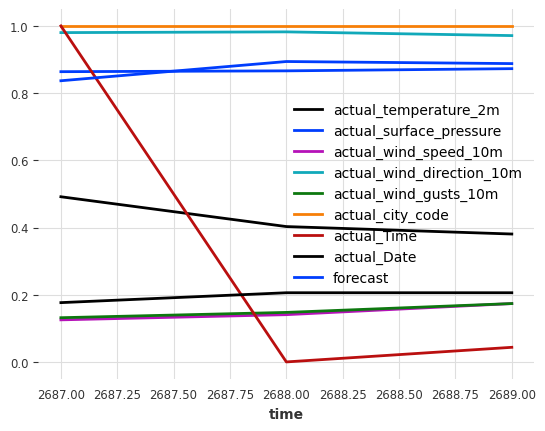

In [21]:
pred_cov = model_pastcov.predict(n=3,                        # n of days to predict
                                 series=train['surface_pressure'][-7:],  # target input for prediction
                                 past_covariates=train[-7:]) # past-covariates input for prediction

val[:3].plot(label="actual")
pred_cov.plot(label="forecast")

In [22]:
real_pred = target_transformer.inverse_transform(pred_cov).values()

In [23]:
real_actual = target_transformer.inverse_transform(val['surface_pressure'][:3]).values()


In [24]:
real_pred.shape,real_actual.shape

((3, 1), (3, 1))

In [25]:
# check the SMAPE Symmetric Mean Absolute Percentage Error

def smape(y_true, y_hat):
    return 200.0 * np.mean(np.abs(y_true - y_hat) / (np.abs(y_true) + np.abs(y_hat)))

smape(real_actual, real_pred)

0.18227163196198748

In [26]:
mae = np.mean(np.abs(real_actual - real_pred))

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 1.8032586210322659


In [27]:
#mean squared error
from sklearn.metrics import mean_squared_error
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)


mse(real_actual, real_pred)

3.454050901955458